Last Edited: 2024-01-25

Changes:
* (01-25) Added code to remove 7 datapoints that cause log(0) to the `fashion_mnist()` function
* (01-25) Fixed some typos



------

- **Deadline**: Feb 5, at 23:59PM.
- **Submission**: You need to submit your solutions through Crowdmark, including all your derivations, plots, and your code. You can produce the files however you like (e.g. LATEX, Microsoft Word, etc), as long as it is readable. Points will be deducted if we have a hard time reading your solutions or understanding the structure of your code.
- **Collaboration policy**: After attempting the problems on an individual basis, you may discuss and work together on the assignment with up to two classmates. However, **you must write your own code and write up your own solutions individually and explicitly name any collaborators** at the top of the homework.



***Collaboration with Yuxi Wang (wang117)***

# Q1 - Decision Theory

One successful use of probabilistic models is for building spam filters, which take in an email and take different actions depending on the likelihood that it’s spam.

Imagine you are running an email service. You have a well-calibrated spam classifier that tells you the probability that a particular email is spam: $p(spam|email)$. You have four options for what to do with each email: You can list it as important email, show it to the user, put it in the spam folder, or delete it entirely.

Depending on whether or not the email really is spam, the user will suffer a different amount  of wasted time for the different actions we can take, $L$(action, spam):

Action   | Spam        | Not spam
-------- | ----------- | -----------
Important| 15         | 0
Show     | 5          | 1
Folder   | 1           | 40
Delete   | 0           | 150

## Q1.1
[3pts] Plot the expected wasted user time for each of the three possible actions, as a function of the probability of spam: $p(spam|email)$.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

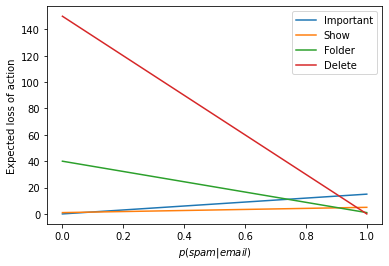

In [ ]:
losses = [[15, 0],[5, 1], [1, 40],[0, 150]]
actions_names = ['Important','Show', 'Folder', 'Delete']
num_actions = len(losses)
def expected_loss_of_action(prob_spam, action):
    #TODO: Return expected loss over a Bernoulli random variable
    # with mean prob_spam.
    # Losses are given by the table above.
    action_loss = losses[action]
    return prob_spam * action_loss[0] + (1 - prob_spam) * action_loss[1]
    
prob_range = np.linspace(0., 1., num=600) 

# Make plot
for action in range(num_actions):
    plt.plot(prob_range, expected_loss_of_action(prob_range, action), label=actions_names[action])

plt.xlabel('$p(spam|email)$')
plt.ylabel('Expected loss of action')
plt.legend()


## Q1.2
[2pts] Write a function that computes the optimal action given the probability of spam.

In [ ]:
def optimal_action(prob_spam):
    #TODO: return best action given the probability of spam. 
    #Hint: np.argmin might be helpful.
    
    losses = []
    for action in range(len(actions_names)):
      losses.append(expected_loss_of_action(prob_spam, action=action))
    choices = np.argmin(np.array(losses), axis=0)
    return choices

## Q1.3
[4pts] Plot the expected loss of the optimal action as a function of the probability of spam.


Color the line according to the optimal action for that probability of spam.


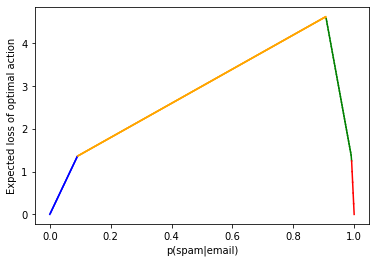

In [ ]:
prob_range = np.linspace(0., 1., num=600) 
optimal_losses = []
optimal_actions = []

optimal_actions = optimal_action(prob_range)
color_pallets = ["blue", "orange", "green", "red"]

for idx, p in enumerate(prob_range):
    # TODO: Compute the optimal action and its expected loss for
    # probability of spam given by p.
    optimal_losses.append(expected_loss_of_action(p, optimal_actions[idx]))

plt.xlabel('p(spam|email)')
plt.ylabel('Expected loss of optimal action')
# plt.plot(prob_range, optimal_losses)

for idx in range(len(prob_range) - 1):
  y = optimal_losses[idx], optimal_losses[idx + 1]
  x = (prob_range[idx], prob_range[idx + 1])
  plt.plot(x, y, color=color_pallets[optimal_actions[idx]])

## Q1.4
[4pts] For exactly which range of the probabilities of an email being spam should we delete an email?

Find the exact answer by hand using algebra.

[Type up your derivation here]

Your answer:

Given the loss of each action, we have the expected loss as a 
function of the probablility of an email being spam. We denote this probability $p$.

We can derive the expected loss for each action:

$$
  \begin{align}
    \mathbb{E}(L\mid action = delete) &= L(delete, spam) \times p + L(delete, \neg spam) \times (1-p)\\
    &= 0 + 150 \times (1 - p)\\
    &= - 150p + 150
  \end{align}
$$

Similarly,

$\mathbb{E}(L\mid action = important) = 15p$

$\mathbb{E}(L\mid action = show) = 4p + 1$

$\mathbb{E}(L\mid action = folder) = -49p + 40$

We now need to find the domain such that the line of deleting email is below all other lines.

$$
  \begin{align}
    \mathcal{l}_{delete} - \mathcal{l}_{important} &\leq 0 \\
    - 150p + 150 - 15p &\leq 0\\
    \frac{150}{165} &\leq p\\ \\
    \mathcal{l}_{delete} - \mathcal{l}_{show} &\leq 0 \\
    - 150p + 150 - (4p + 1) &\leq 0\\
    \frac{149}{154} &\leq p\\\\
    \mathcal{l}_{delete} - \mathcal{l}_{folder} &\leq 0 \\
    - 150p + 150 - (-39p + 40) &\leq 0\\
    \frac{110}{111} &\leq p
  \end{align}
$$

Finally, we take the intersection of these domain, and we have $\frac{110}{111} \leq p \leq 1$

# Q2 - Naïve Bayes, A Generative Model

![](https://github.com/zalandoresearch/fashion-mnist/blob/master/doc/img/fashion-mnist-sprite.png?raw=true)


In this question, we'll fit a Naïve Bayes model to the fashion MNIST dataset, and use this model for making predictions and generating new images from the same distribution. Fashion MNIST is a dataset of 28x28 black-and-white images of items of clothing. We represent each image by a vector $x^{(i)} \in \{0,1\}^{784}$, where 0 and 1 represent white and black pixels respectively. Each class label $c^{(i)}$ is a different item of clothing, which in the code is represented by a 10-dimensional one-hot vector.

The Naïve Bayes model parameterized by $\theta$ and $\pi$ defines the following joint probability of $x$ and $c$,
$$p(x,c|\theta,\pi) = p(c|\pi)p(x|c,\theta) = p(c|\pi)\prod_{j=1}^{784}p(x_j|c,\theta),$$
where $x_j | c,\theta \sim \operatorname{Bernoulli}(\theta_{jc})$ or in other words $p(x_j | c,\theta) = \theta_{jc}^{x_j}(1-\theta_{jc})^{1-x_j}$, and $c|\pi$ follows a simple categorical distribution, i.e. $p(c|\pi) = \pi_c$.

We begin by learning the parameters $\theta$ and $\pi$. The following code will download and prepare the training and test sets.

In [2]:
import numpy as np
import os
import gzip
import struct
import array
import matplotlib.pyplot as plt
import matplotlib.image
from urllib.request import urlretrieve

def download(url, filename):
    if not os.path.exists('data'):
        os.makedirs('data')
    out_file = os.path.join('data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


def fashion_mnist():
    base_url = 'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/'

    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(base_url + filename, filename)

    train_images = parse_images('data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('data/train-labels-idx1-ubyte.gz')
    test_images = parse_images('data/t10k-images-idx3-ubyte.gz')
    test_labels = parse_labels('data/t10k-labels-idx1-ubyte.gz')
    # Remove the data point that cause log(0)
    remove = (14926, 20348, 36487, 45128, 50945, 51163, 55023)
    train_images = np.delete(train_images,remove, axis=0)
    train_labels = np.delete(train_labels, remove, axis=0)
    return train_images, train_labels, test_images[:1000], test_labels[:1000]


def load_fashion_mnist():
    partial_flatten = lambda x: np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:, None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels =  fashion_mnist()
    train_images = (partial_flatten(train_images) / 255.0 > .5).astype(float)
    test_images = (partial_flatten(test_images) / 255.0 > .5).astype(float)
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]

    return N_data, train_images, train_labels, test_images, test_labels

## Q2.1
[2pts] Derive the expression for the Maximum Likelihood Estimator (MLE) of $\theta$ and $\pi$.

**Answer:**

Suppose that we have a dataset $\mathcal{D} = \{(x^{(i)}, c^{(i)}) \mid i \in [1, N]\}$. First we have the likelihood function:

$$
  \begin{align}
  \mathcal{L}(\mathcal{D}\mid \theta, π) &=
    \prod_{i=1}^{N} p(x^{(i)}, c^{(i)} \mid \theta)\\
    &=\prod_{i=1}^{N} p(c^{(i)} \mid \pi) \prod_{j=1}^{784} \theta_{jc^{(i)}}^{x_j^{(i)}}(1-\theta_{jc^{(i)}})^{1-x_j^{(i)}}
  \end{align}
$$

Then, we take the logarithm to get log-likelihood:

$$
  \begin{align}
  \mathcal{l}(\mathcal{D}\mid \theta, π) &=
    \sum_{i=1}^{N} \log p(c^{(i)} \mid \pi) \sum_{j=1}^{784} {x_j^{(i)}}\log\theta_{jc^{(i)}} + ({1-x_j^{(i)}}) \log(1-\theta_{jc^{(i)}})
  \end{align}
$$

We take derivative w.r.t. $\theta_{jc}$ and set it to zero:

$$
  \begin{align}
  &\frac{d}{d\theta_{jc}}\sum_{i=1}^{N} \log p(c^{(i)} \mid \pi) \sum_{j=1}^{784} {x_j^{(i)}}\log\theta_{jc^{(i)}} + ({1-x_j^{(i)}}) \log(1-\theta_{jc^{(i)}})\\
  &= \sum_{i=1}^{N} \mathbb{I}[c^{(i)} = c] (\frac{x_j^{(i)}}{\theta_{jc}} - \frac{1-x_j^{(i)}}{1-\theta_{jc}})\\
  \text{Let} \; S = \{i \in \mathbb{Z} \mid c^{(i)} = c\}\\
  &=\sum_{i\in S}(\frac{x_j^{(i)}}{\theta_{jc}} - \frac{1-x_j^{(i)}}{1-\theta_{jc}})\\
  &= \sum_{i\in S}\frac{x_j^{(i)} - \theta_{jc}}{\theta_{jc}(1-\theta_{jc})} = 0\\
  & \sum_{i\in S}{x_j^{(i)} - \theta_{jc}} = 0\\
  & \hat{\theta}_{jc} = \frac{\sum_{i\in S}x_j^{(i)}}{\mid S \mid}
  \end{align}
$$
For $\pi_c$, since each label $c$ is a one-hot vector, we can treat 
$c^{(i)}$ as a Bernoulli random variable because the degrees of freedom is 2, i.e. knowing the position of the only $1$ tells that every other position is $0$.
This is equal to maximize w.r.t. $\pi$, i.e. $\hat{\pi}_c = argmax\;_{\pi_c} \mathcal{l}(\pi_c)$, 

$$
  \begin{align}
&\prod_{i=1}^{N} p(c^{(i)} \mid \pi) = \prod_{i=1}^{N} \pi_{c^{(i)}}^{\mathbb{I}[c^{(i)}=c]}(1- \pi_{c^{(i)}})^{1-\mathbb{I}[c^{(i)}=c]}\\
\text{ Take the logarithm}\\
&=\sum_{i=1}^{N}\mathbb{I}[c^{(i)}=c]\log\pi_{c^{(i)}}+({1-\mathbb{I}[c^{(i)}=c]})\log(1- \pi_{c^{(i)}})\\
\text{ Take derivative w.r.t. $\pi_c$ and set it to zero:}\\
\frac{\sum_{i=1}^{N}\mathbb{I}[c^{(i)}=c]}{\pi_{c}} &= \frac{\sum_{i=1}^{N}1-\mathbb{I}[c^{(i)}=c]}{1-\pi_{c}}\\
  \hat{\pi_c} &= \frac{\sum_{i=1}^{N}\mathbb{I}[c^{(i)}=c]}{\sum_{i=1}^{N}\mathbb{I}[c^{(i)}=c]+\sum_{i=1}^{N}1-\mathbb{I}[c^{(i)}=c]}\\
  &= \frac{\sum_{i=1}^{N}\mathbb{I}[c^{(i)}=c]}{\sum_{i=1}^{N}1}\\
  &= \frac{\mid S \mid}{N}\\
  \end{align}
$$


## Q2.2
[4pts] Using the MLE for this data, many entries of $\theta$ will be estimated to be 0, which seems extreme. So we look for another estimation method.

Assume the prior distribution of $\theta$ is such that the entries are i.i.d. and drawn from $\operatorname{Beta}(2,2)$. Derive the Maximum A Posteriori (MAP) estimator for $\theta$ (it has a simple final form). You can return the MLE for $\pi$ in your implementation. From now on, we will work with this estimator.

**Answer:**

Given that the prior $p(\theta_{jc})$ is a $Beta(\alpha, \beta)$ distribution,

$$\hat{\theta}{jc} = \operatorname{argmax}_{\theta_{jc}} \mathcal{L}(D \mid \theta) \cdot Beta(\alpha, \beta)$$
$$
\begin{align}
\mathcal{L}(D \mid \theta_{jc}) \cdot p(\theta_{jc}\mid \alpha, \beta) &∝ \left(\prod_{i=1}^{N} \mathbb{I}[c^{(i)} = c] \cdot \theta_{jc}^{x_j^{(i)}}(1-\theta_{jc})^{1-x_j^{(i)}}\right) \cdot \frac{\Gamma(\alpha + \beta)}{\mathcal{\Gamma(\alpha)\Gamma(\beta)}} \cdot \theta_{jc}^{\alpha-1}(1-\theta_{jc})^{\beta-1}\\
&\propto \left(\prod_{i\in S} \theta_{jc}^{x_j^{(i)}}(1-\theta_{jc})^{1-x_j^{(i)}}\right) \cdot \frac{\Gamma(\alpha + \beta)}{\mathcal{\Gamma(\alpha)\Gamma(\beta)}} \cdot \theta_{jc}^{\alpha-1}(1-\theta_{jc})^{\beta-1}\\
&\propto \left(\theta_{jc}^{\sum_{i\in S} x_j^{(i)}}(1-\theta_{jc})^{\sum_{i\in S} 1-x_j^{(i)}}\right) \cdot \frac{\Gamma(\alpha + \beta)}{\mathcal{\Gamma(\alpha)\Gamma(\beta)}} \cdot \theta_{jc}^{\alpha-1}(1-\theta_{jc})^{\beta-1}\\
&\propto \frac{\Gamma(\alpha + \beta)}{\mathcal{\Gamma(\alpha)\Gamma(\beta)}} \cdot (\theta_{jc}^{\sum_{i\in S} x_j^{(i)} + \alpha - 1}(1-\theta_{jc})^{\sum_{i\in S} 1-x_j^{(i)} + \beta - 1}) \\
&∝ Beta(\sum_{i\in S} x_j^{(i)} + 2, \mid S \mid - \sum_{i\in S} x_j^{(i)} + 2)
\end{align}
$$

We know the mode of Beta distribution, so is:

$$\hat{\theta}{jc} = \frac{\sum_{i\in S} x_j^{(i)} + 1}{\mid S \mid + 2}$$


In [5]:
def train_map_estimator(train_images, train_labels):
  """ Inputs: train_images (N_samples x N_features), train_labels (N_samples x N_classes)
      Returns the MAP estimator theta_est (N_features x N_classes) and the MLE
      estimator pi_est (N_classes)"""
    
  # YOU NEED TO WRITE THIS PART
  theta_est = []
  pi_est = []
  for c in range(train_labels.shape[1]):
    tmp = []
    for j in range(train_images.shape[1]):
      tmp.append((np.sum(train_images[:, j] * train_labels[:, c]) + 1) / (np.sum(train_labels[:, c]) + 2))
    theta_est.append(tmp)
    pi_est.append(np.sum(train_labels[:, c]) / train_labels.shape[0])
  return np.array(theta_est).T, np.array(pi_est)

## Q2.3
[5pts] Derive an expression for the class log-likelihood $\log p(c|x,\theta,\pi)$ for a single image. Then, complete the implementation of the following functions. Recall that our prediction rule is to choose the class that maximizes the above log-likelihood, and accuracy is defined as the fraction of samples that are correctly predicted.

Report the average log-likelihood $\frac{1}{N}\sum_{i=1}^{N}\log p(c^{(i)}|x^{(i)},\hat{\theta},\hat{\pi})$ (where $N$ is the number of samples) on the training test, as well the training and test errors.

**Answer:**


$$\log p(c|x,\theta,\pi) = \log \frac{p(c, x, \theta, \pi)}{p(x, \theta, \pi)} = \log \frac{p(c, x \mid \theta, \pi)p(\theta, \pi)}{p(x \mid \theta, \pi)p(\theta, \pi)} =\log \frac{p(x,c|\theta,\pi)}{p(x|\theta,\pi)} = \log \frac{p(c|\pi)p(x|c,\theta)}{\sum_{c'}p(c'|\pi)p(x|c',\theta)}$$

Substitute $p(x,c|\theta,\pi)$ and $p(x_j\mid c, \theta)$:

$$\log p(c|x,\theta,\pi) = \log \pi_c + \sum_{j=1}^{784} \left(x_j \log \theta_{jc} + (1 - x_j) \log (1 - \theta_{jc}) \right) -  \log\sum_{c'}\left( \pi_{c'}  \prod_{j=1}^{784} \theta_{jc'}^{x_j}(1-\theta_{jc'})^{(1-x_j)}\right)$$

In [6]:
def log_likelihood(images, theta, pi):
    """ Inputs: images (N_samples x N_features), theta, pi
        Returns the matrix 'log_like' of loglikehoods over the input images where
        log_like[i,c] = log p (c |x^(i), theta, pi) using the estimators theta and pi.
        log_like is a matrix of (N_samples x N_classes)
    Note that log likelihood is not only for c^(i), it is for all possible c's."""

    # YOU NEED TO WRITE THIS PART
    log_like = np.zeros((images.shape[0], len(pi)))
    for i in range(images.shape[0]):
      t3 = 0.0
      for c in range(len(pi)):
        t3 += np.exp(np.log(pi[c]) + np.sum(images[i] * np.log(theta[:, c]) + (1 - images[i]) * (np.log(1 - theta[:, c]))))
      for c in range(len(pi)):
        t1 = np.log(pi[c])
        t2 = np.sum(images[i] * np.log(theta[:, c]) + (1 - images[i]) * (np.log(1 - theta[:, c])))
        
        log_like[i, c] = t1 + t2 - np.log(t3)

    return log_like


def accuracy(log_like, labels):
    """ Inputs: matrix of log likelihoods and 1-of-K labels (N_samples x N_classes)
    Returns the accuracy based on predictions from log likelihood values"""

    # YOU NEED TO WRITE THIS PART
    return np.sum(np.argmax(log_like, axis=1) == np.argmax(labels, axis=1)) / labels.shape[0]


N_data, train_images, train_labels, test_images, test_labels = load_fashion_mnist()
theta_est, pi_est = train_map_estimator(train_images, train_labels)

loglike_train = log_likelihood(train_images, theta_est, pi_est)
avg_loglike = np.sum(loglike_train * train_labels) / N_data
train_accuracy = accuracy(loglike_train, train_labels)
loglike_test = log_likelihood(test_images, theta_est, pi_est)
test_accuracy = accuracy(loglike_test, test_labels)

print(f"Average log-likelihood for MAP is {avg_loglike:.3f}")
print(f"Training accuracy for MAP is {train_accuracy:.3f}")
print(f"Test accuracy for MAP is {test_accuracy:.3f}")

Average log-likelihood for MAP is -34.231
Training accuracy for MAP is 0.651
Test accuracy for MAP is 0.638


## Q2.4
[2pts] Given this model's assumptions, is it always true that any two pixels $x_i$ and $x_j$ with $i \neq j$ are indenepdent given $c$? How about after marginalizing over $c$? Explain your answer.

**Answer:**

To prove that $x_i$ and $x_j$ are independent, we can prove for $p(x_i \mid x_j) = p(x_i)$, where $i \neq j$.

We know from Naive Bayes assumption that $x_i$ and $x_j$ are independent give $c$, that is $p(x_i \mid x_j, c) = p(x_i \mid c)$.

$$
p(x_i\mid x_j) = \sum_{c}p(x_i \mid x_j, c)p(c\mid x_j) \neq \sum_{c}p(x_i\mid c)p(c) = p(x_i)
$$

Thus, we have shown that $x_i$ and $x_j$ are not independent.


## Q2.5 
[4pts] Since we have a generative model for our data, we can do more than just prediction. Randomly sample and plot 10 images from the learned distribution using the MAP estimates. (Hint: You first need to sample the class $c$, and then sample pixels conditioned on $c$.)

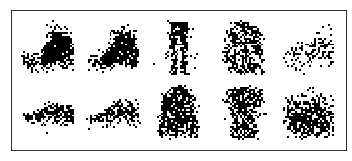

In [7]:
def image_sampler(theta, pi, num_images):
    """ Inputs: parameters theta and pi, and number of images to sample
    Returns the sampled images (N_images x N_features)"""

    # YOU NEED TO WRITE THIS PART
    t = np.random.choice(range(len(pi)), p=pi, size=num_images)
    sample_images = np.zeros((num_images, theta.shape[0]))
    for i in range(num_images):
      for j in range(theta.shape[0]):
        sample_images[i][j] += np.random.binomial(1, theta[j, t[i]])
    return sample_images



def plot_images(images, ims_per_row=5, padding=5, image_dimensions=(28, 28),
                cmap=matplotlib.cm.binary, vmin=0., vmax=1.):
    """Images should be a (N_images x pixels) matrix."""
    fig = plt.figure(1)
    fig.clf()
    ax = fig.add_subplot(111)

    N_images = images.shape[0]
    N_rows = np.int32(np.ceil(float(N_images) / ims_per_row))
    pad_value = vmin
    concat_images = np.full(((image_dimensions[0] + padding) * N_rows + padding,
                             (image_dimensions[1] + padding) * ims_per_row + padding), pad_value)
    for i in range(N_images):
        cur_image = np.reshape(images[i, :], image_dimensions)
        row_ix = i // ims_per_row
        col_ix = i % ims_per_row
        row_start = padding + (padding + image_dimensions[0]) * row_ix
        col_start = padding + (padding + image_dimensions[1]) * col_ix
        concat_images[row_start: row_start + image_dimensions[0],
                      col_start: col_start + image_dimensions[1]] = cur_image
        cax = ax.matshow(concat_images, cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    
    plt.plot()


sampled_images = image_sampler(theta_est, pi_est, 10)
plot_images(sampled_images)

## Q2.6
[4pts] One of the advantages of generative models is that they can handle missing data, or be used to answer different sorts of questions about the model. Assume we have only observed some pixels of the image. Let $x_E = \{x_p : \text{pixel $p$ is observed}\}$. Derive an expression for $p(x_j|x_E,\theta,\pi)$, the conditional probability of an unobserved pixel $j$ given the observed pixels and distribution parameters. (Hint: You have to marginalize over $c$.)

**Answer:**

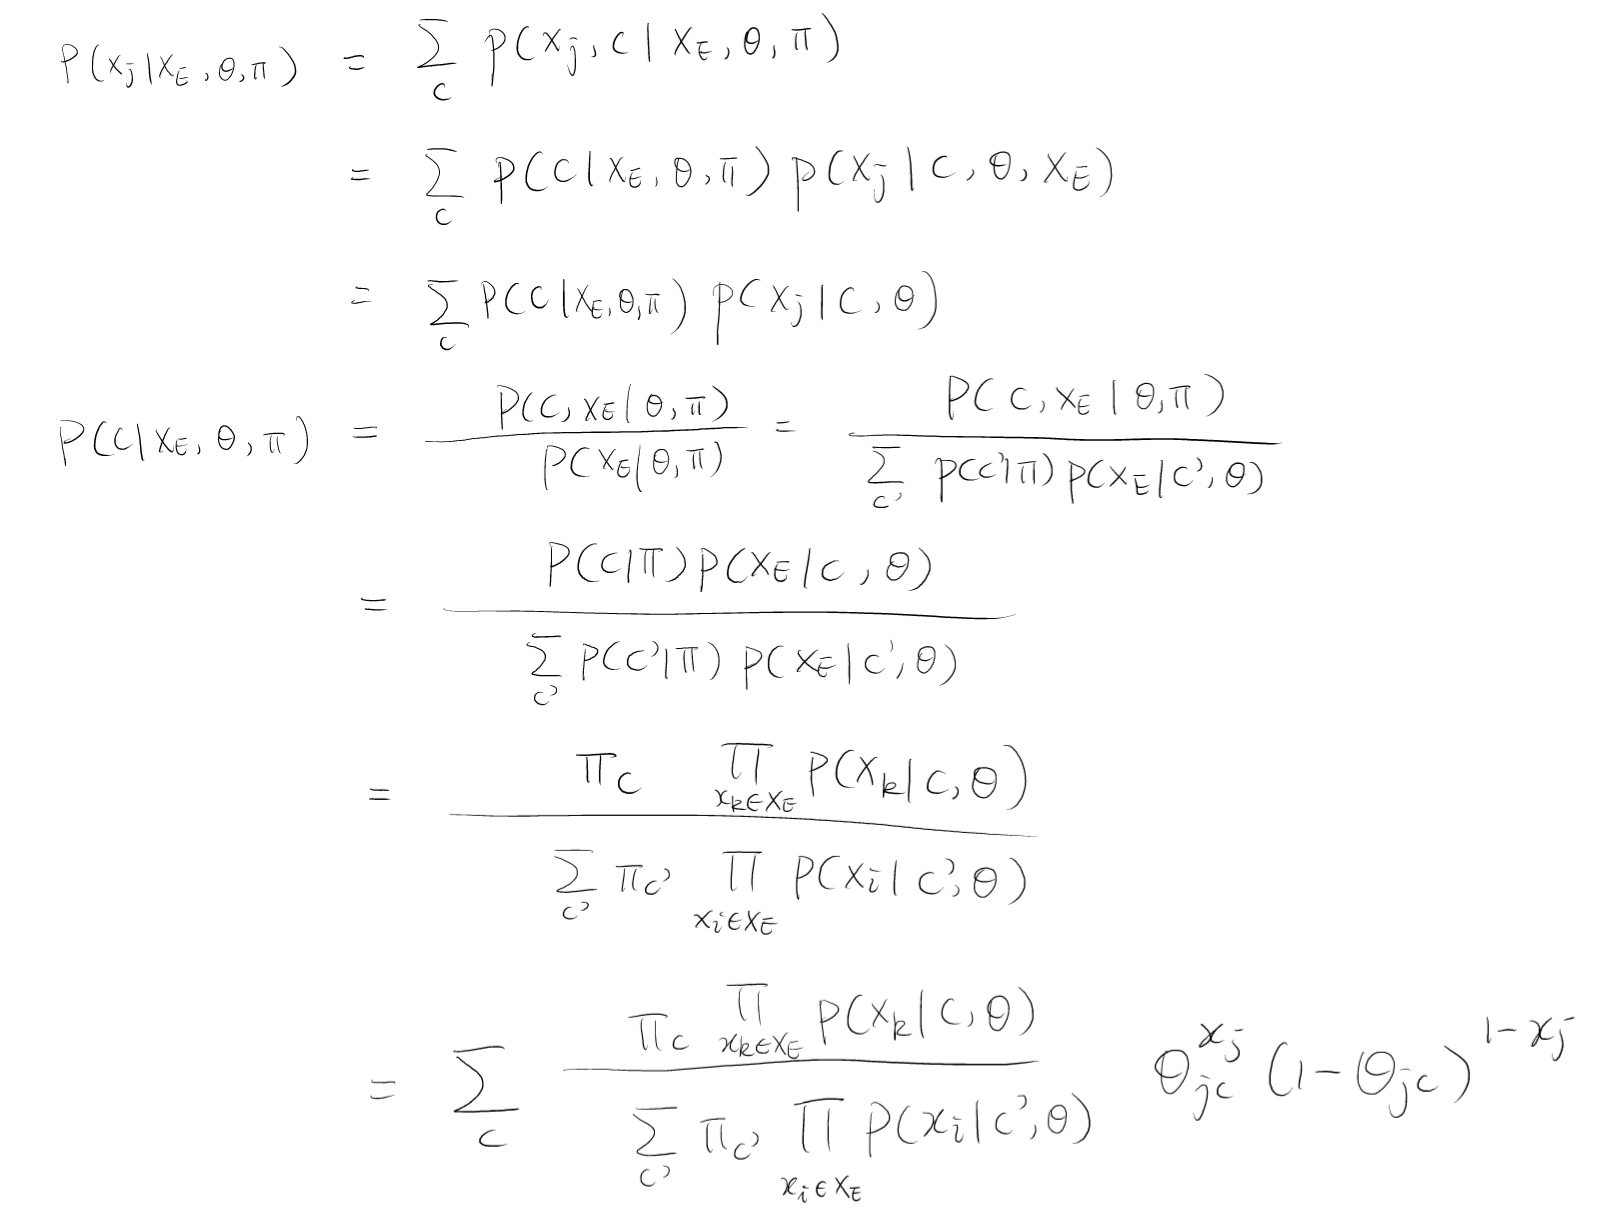


## Q2.7
[4pts] We assume that only 30% of the pixels are observed. For the first 20 images in the training set, plot the images when the unobserved pixels are left as white, as well as the same images when the unobserved pixels are filled with the marginal probability of the pixel being 1 given the observed pixels, i.e. the value of the unobserved pixel $j$ is $p(x_j = 1|x_E,\theta,\pi)$.

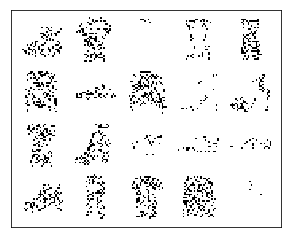

In [31]:
def probabilistic_imputer(theta, pi, original_images, is_observed):
    """Inputs: parameters theta and pi, original_images (N_images x N_features), 
        and is_observed which has the same shape as original_images, with a value
        1. in every observed entry and 0. in every unobserved entry.
    Returns the new images where unobserved pixels are replaced by their 
    conditional probability"""
    
    # YOU NEED TO WRITE THIS PART
    x_E = original_images * is_observed
    x_E_inverse = (1 - original_images) * is_observed
    p_x_E = np.exp(x_E @ np.log(theta) + x_E_inverse @ np.log(1 - theta) + np.log(pi))  
        
    p_x_j = (theta @ p_x_E.T) / np.sum(p_x_E, axis=1)

    return original_images * is_observed + p_x_j.T * (1 - is_observed)


num_features = train_images.shape[1]
is_observed = np.random.binomial(1, p=0.3, size=(20, num_features))
plot_images(train_images[:20] * is_observed)

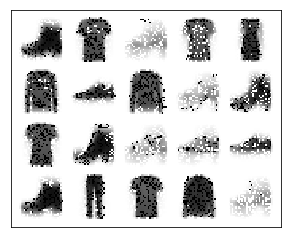

In [32]:
imputed_images = probabilistic_imputer(theta_est, pi_est, train_images[:20], is_observed)
plot_images(imputed_images)